## Classical AB Testing

In [46]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import scipy
from scipy import stats
import sys
import os


import scipy.stats as scs

from stats import pooled_SE, confidence_interval, ab_dist, p_val, z_val

ModuleNotFoundError: No module named 'stats'

In [45]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
#from plot import *

In [34]:
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
# reading the csv file
missing_values = ["n/a", "na", "undefined"]
df = pd.read_csv("../data/AdSmartABdata.csv", na_values=missing_values)
df

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [4]:
df.shape

(8077, 9)

In [5]:
temp_df = df.query("not (yes == 0 & no == 0)")
temp_df.shape

(1243, 9)

In [7]:
#Dropping users who have not responded
cleaned_df = temp_df[['auction_id', 'experiment', 'yes', 'no']]
cleaned_df['aware'] = 0
cleaned_df.loc[cleaned_df['yes'] == 1, 'aware'] = 1
cleaned_df.loc[cleaned_df['yes'] == 0, 'aware'] = 0
cleaned_df.drop(columns=['yes', 'no'], inplace=True)
clean_df = cleaned_df.set_index('auction_id')
cleaned_df

,auction_id,experiment,aware
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,0
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,1
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,1
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,0
...,...,...,...
8059,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,1
8063,ffb176df-ecd2-45d3-b05f-05b173a093a7,exposed,1
8064,ffb79718-6f25-4896-b6b3-e58b80a6e147,control,0
8069,ffca1153-c182-4f32-9e90-2a6008417497,control,0


In [9]:
summary_df = clean_df.pivot_table( index='experiment', aggfunc='sum')
summary_df['total'] = clean_df.pivot_table( index='experiment', aggfunc='count')
summary_df['% of awareness'] = clean_df.pivot_table( index='experiment')
summary_df['not aware'] = summary_df['total'] - summary_df['aware']
summary_df = summary_df.reindex(['aware', 'not aware', 'total', '% of awareness'], axis=1)
summary_df

,aware,not aware,total,% of awareness
experiment,,,,
control,264,322,586,0.450512
exposed,308,349,657,0.468798


In [10]:
exp_rate = summary_df['% of awareness']['exposed']
cont_rate = summary_df['% of awareness']['control']
exp_rate

0.4687975646879756

In [12]:
diff = exp_rate - cont_rate
print(f'The difference between conversion rates of the exposed and control groups is {diff}.')

The difference between conversion rates of the exposed and control groups is 0.018285619295484168.


To be confident of our result, we will perform hypothesis testing.

## Probability Distributions

In [16]:
exp_aware = summary_df['aware']['exposed']
cont_aware = summary_df['aware']['control']
exp_total = summary_df['total']['exposed']
cont_total = summary_df['total']['control']

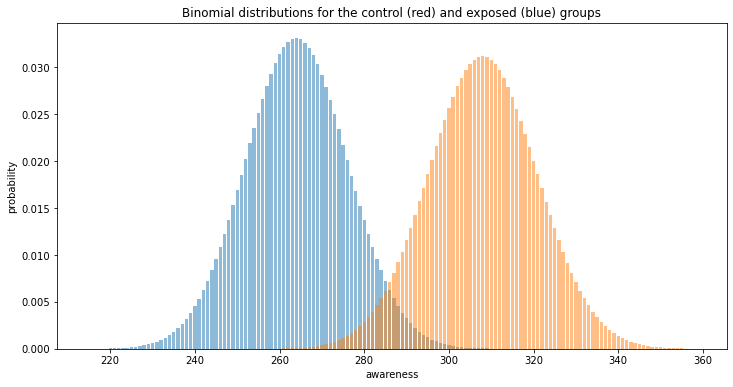

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

xC = np.linspace(cont_aware - 49, cont_aware + 50, 100)
yC = scs.binom(cont_total, cont_rate).pmf(xC)
ax.bar(xC, yC, alpha=0.5, linestyle='--')
xE = np.linspace(exp_aware - 49, exp_aware + 50, 100)
yE = scs.binom(exp_total , exp_rate).pmf(xE)
ax.bar(xE, yE, alpha=0.5, linestyle='--')
plt.xlabel('awareness')
plt.ylabel('probability')
plt.title("Binomial distributions for the control (red) and exposed (blue) groups")
plt.show()

The distribution in blue is the probability of users being aware of the brand LUX for the control group, while the distribution in orange is the probability of users being aware of the brand LUX for the exposed group. As we can see there is a difference between the mean of the two distributions. 

## Standardize the probability distribution for control and exposed groups

In [19]:
# standard error of the mean
SE_C = np.sqrt(cont_rate * (1-cont_rate)) / np.sqrt(cont_total)
SE_E = np.sqrt(exp_rate * (1-exp_rate)) / np.sqrt(exp_total)

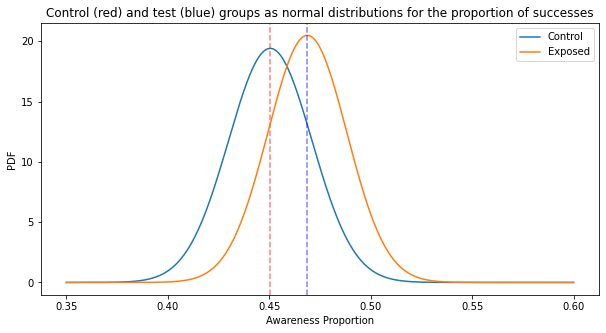

In [21]:
# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(10, 5))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(cont_rate, SE_C).pdf(x)
ax.plot(x, yC, label='Control')
ax.axvline(x=cont_rate, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(exp_rate, SE_E).pdf(x)
ax.plot(x, yE, label='Exposed')
ax.axvline(x=exp_rate, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Awareness Proportion')
plt.ylabel('PDF')
plt.title("Control (red) and test (blue) groups as normal distributions for the proportion of successes")
plt.show()

In [22]:
std_cont = np.sqrt(cont_rate * (1 - cont_rate) / cont_total)
std_exp = np.sqrt(exp_rate * (1 - exp_rate) / exp_total)
std_cont, std_exp

(0.02055339057798332, 0.019468837373132736)

## Compare the Null Hypothesis vs. the Alternative Hypothesis

### The null hypothesis: the position that the advertising campaign for the test group would result in no change in the LUX brand awareness.
    
### The alternative hypothesis: the opposing position that the adverstising campaign for the test group would result in an improvement of the brand awareness.

In [36]:
def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(N_A, N_B, bcr, d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()


NameError: name 'pooled_SE' is not defined

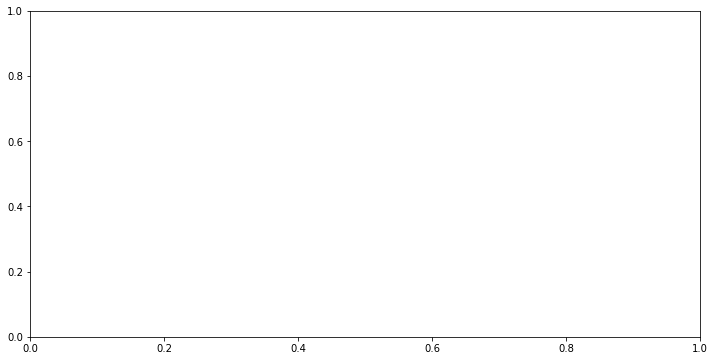

In [41]:
abplot(cont_total, exp_total, cont_rate, diff)


In [42]:
z_score = (diff) / np.sqrt(std_cont**2 + std_exp**2)
p_value = scs.norm().sf(z_score)
z_score, p_value

(0.6458981015684259, 0.2591726745827285)

NameError: name 'pooled_SE' is not defined

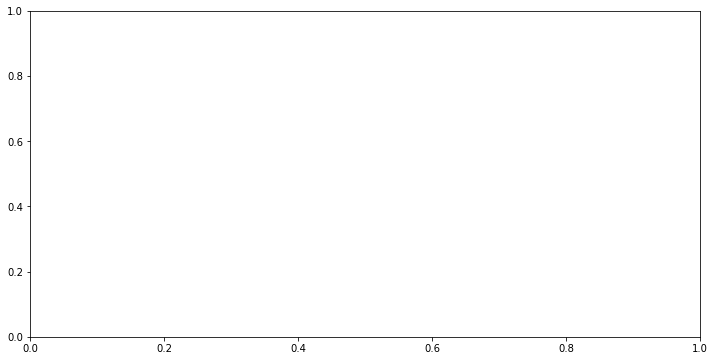

In [43]:
abplot(cont_total, exp_total, cont_rate, diff, show_power=True, show_beta=True, show_alpha=True, show_p_value=True)